In [15]:
import os
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '4' 

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [16]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [17]:
# GLOBAL VARIABLES
dataset = "animals"
base_dir = os.path.join("datasets", dataset)
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")
augmented_dir = os.path.join(base_dir, "aug")
os.makedirs(augmented_dir, exist_ok=True)

models_dir = os.path.join("models", dataset)
os.makedirs(models_dir, exist_ok=True)

metadata_file = os.path.join(models_dir, "metadata.csv")
metrics_file = os.path.join(models_dir, "metrics.csv")

# HYPERPARAMETERS
HYPERPARAMETERS = {
    "model_version": 12,
    # Image processing
    "img_width": 64,
    "img_height": 64,
    "rescale": 1.0 / 255,
    "rotation_range": 10,
    "width_shift_range": 0.2,
    "zoom_range": 0.3,
    "horizontal_flip": True,
    # Training
    "batch_size": 32,
    # Model
    "num_classes": 90,
    "learning_rate": 0.001,
}

epochs = 100

In [18]:
import hashlib

# USING THE HYPERPARAMETERS GENERATE A KEY (HASH)
def generate_hash():
    hash_input = ""
    for key, value in HYPERPARAMETERS.items():
        if isinstance(value, list):
            value = str(value)
        hash_input += f"{key}:{value};"
    # Generate a hash
    return hashlib.md5(hash_input.encode()).hexdigest()

In [19]:
hash_key = generate_hash()

if not os.path.exists(metadata_file):
    cols = ["hash_key"]
    cols.extend(HYPERPARAMETERS.keys())
    metadata = pd.DataFrame(columns=cols)
    metadata.to_csv(metadata_file, index=False)
    
metadata = pd.read_csv(metadata_file)
if hash_key not in metadata["hash_key"].values:
    metadata = pd.read_csv(metadata_file)
    new_row = {**HYPERPARAMETERS, "hash_key": hash_key}
    metadata = pd.concat([metadata, pd.DataFrame([new_row])], ignore_index=True)
    metadata.to_csv(metadata_file, index=False)

In [20]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=10,
    width_shift_range=0.2,
    zoom_range=0.3,
    horizontal_flip=HYPERPARAMETERS["horizontal_flip"],
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(HYPERPARAMETERS["img_width"], HYPERPARAMETERS["img_height"]),
    batch_size=HYPERPARAMETERS["batch_size"],
    class_mode="binary",
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    class_mode="binary",
    target_size=(HYPERPARAMETERS["img_width"], HYPERPARAMETERS["img_height"]),
    batch_size=20,
)

Found 4320 images belonging to 90 classes.
Found 1080 images belonging to 90 classes.


In [21]:
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout,
    BatchNormalization,
    Input,
)

model = models.Sequential()
model.add(
    Input(
        shape=(HYPERPARAMETERS["img_width"], HYPERPARAMETERS["img_height"], 3),
    )
)
model.add(Conv2D(32, kernel_size=3, activation="relu"))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=3, activation="relu"))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=5, strides=2, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.4))


model.add(Conv2D(64, kernel_size=5, strides=2, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Conv2D(256, kernel_size=4, activation="relu"))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(HYPERPARAMETERS["num_classes"], activation="softmax"))

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 60, 60, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 60, 60, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 30, 30, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 15, 15, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 15, 15, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 12, 12, 256)    │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 90)             │     3,317,850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,668,954 (14.00 MB)

 Trainable params: 3,668,122 (13.99 MB)

 Non-trainable params: 832 (3.25 KB)

In [22]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(
            models_dir,
            hash_key,
            "{epoch:02d}",
            "model-{loss:.4f}.keras",
        ),
        save_freq=len(train_generator) * 5,
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.2,
        patience=3,
        min_lr=0.000001,
        min_delta=0.001,
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
    ),
]

In [23]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=optimizers.Adam(learning_rate=HYPERPARAMETERS["learning_rate"]),
    metrics=["acc"],
)

In [24]:
histories = []

In [25]:
start_epoch = 0
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=epochs,
    initial_epoch=start_epoch,
    verbose=1,
    callbacks=callbacks,
    validation_data=test_generator,
)

histories.append(history)

Epoch 1/100


/home/cajas/Archivos/tec/semestre_8/tc3002b/ml_benji/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


135/135 ━━━━━━━━━━━━━━━━━━━━ 31s 158ms/step - acc: 0.0239 - loss: 7.8365 - val_acc: 0.0167 - val_loss: 9.6124 - learning_rate: 0.0010
Epoch 2/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 21s 157ms/step - acc: 0.0420 - loss: 10.3856 - val_acc: 0.0111 - val_loss: 12.9035 - learning_rate: 0.0010
Epoch 3/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 22s 160ms/step - acc: 0.0510 - loss: 10.1933 - val_acc: 0.0204 - val_loss: 8.0461 - learning_rate: 0.0010
Epoch 4/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 22s 161ms/step - acc: 0.0564 - loss: 8.6985 - val_acc: 0.0537 - val_loss: 6.1890 - learning_rate: 0.0010
Epoch 5/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 21s 159ms/step - acc: 0.0637 - loss: 7.9051 - val_acc: 0.0463 - val_loss: 5.0389 - learning_rate: 0.0010
Epoch 6/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 21s 155ms/step - acc: 0.0810 - loss: 6.1318 - val_acc: 0.0944 - val_loss: 6.5171 - learning_rate: 0.0010
Epoch 7/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 21s 158ms/step - acc: 0.0927 - loss: 5.4193 - val_acc: 0.0519 - val_loss: 4.8635 - learning_

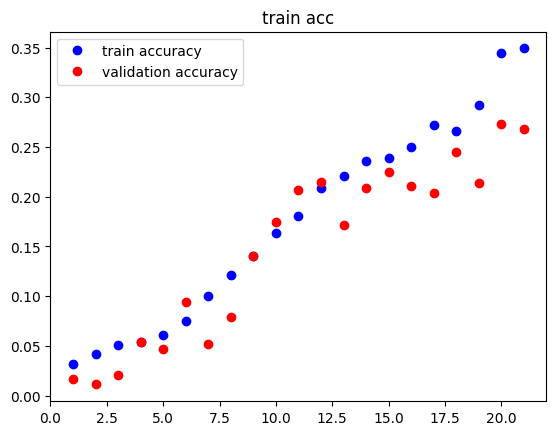

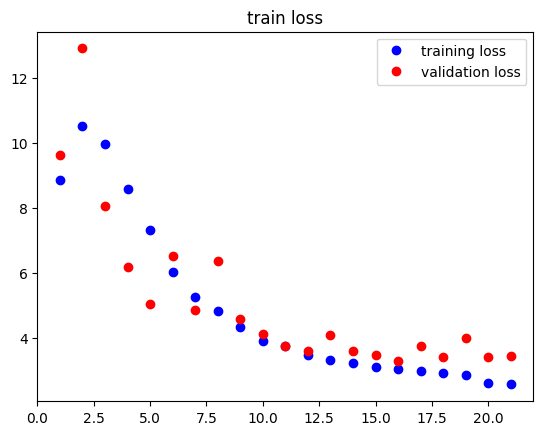

In [26]:
acc = histories[0].history['acc']
for i in range(1, len(histories)):
    acc = np.concatenate((acc, histories[i].history['acc']))

val_acc = histories[0].history['val_acc']
for i in range(1, len(histories)):
    val_acc = np.concatenate((val_acc, histories[i].history['val_acc']))

loss = histories[0].history['loss']
for i in range(1, len(histories)):
    loss = np.concatenate((loss, histories[i].history['loss']))

val_loss = histories[0].history['val_loss']
for i in range(1, len(histories)):
    val_loss = np.concatenate((val_loss, histories[i].history['val_loss']))

epochs_range = range(1, len(acc) + 1)

plt.plot(epochs_range, acc, "bo", label="train accuracy")
plt.plot(epochs_range, val_acc, "ro", label="validation accuracy")
plt.title("train acc")
plt.legend()

plt.figure()

plt.plot(epochs_range, loss, "bo", label="training loss")
plt.plot(epochs_range, val_loss, "ro", label="validation loss")
plt.title("train loss")
plt.legend()

plt.show()

In [27]:
test_generator.reset()
test_loss, test_acc = model.evaluate(test_generator)
print("\ntest acc :\n", test_acc)

54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - acc: 0.2646 - loss: 3.4300

test acc :
 0.26759257912635803
